# Pitching airfoil example 2

This notebook will solve the flow about a pitching airfoil with a semicircular leading edge and wedge-shaped trailing edge. This case was studied experimentally by Yuanhang Zhu at UVa

In [1]:
using ViscousFlow

In [2]:
using Plots
pythonplot()

#=
This is for purposes of rotating the plots, from the body-fixed coordinate system in which they are solved,
to the inertial coordinate system.
=#
import PythonPlot.matplotlib as mpl
using PythonPlot.PythonCall
anim = pyimport("matplotlib.animation")

Python: <module 'matplotlib.animation' from '/Users/jeff/JuliaProjects/MassivelySeparatedFlows/.CondaPkg/env/lib/python3.11/site-packages/matplotlib/animation.py'>

Let's define a macro that allows us to visualize the kinematics
of the body from the perspective of the inertial reference frame.

In [3]:
macro animate_motion(b,m,dt,tmax,xlim,ylim)
    return esc(quote
            bc = deepcopy($b)
            t0, x0 = 0.0, init_motion_state(bc,$m)
            dxdt = zero(x0)
            x = copy(x0)
            @gif for t in t0:$dt:t0+$tmax
                motion_rhs!(dxdt,x,($m,bc),t)
                global x += dxdt*$dt
                update_body!(bc,x,$m)
                plot(bc,xlims=$xlim,ylims=$ylim)
            end every 5
        end)
end

@animate_motion (macro with 1 method)

Set the Reynolds number and the CFL number

In [4]:
my_params=Dict()
my_params["Re"] = 1500  # This is not really the Reynolds number, but really just 1/viscosity. See below, where the actual Reynolds number is computed
my_params["CFL"] = 0.35
my_params["freestream angle"] = 0.0

0.0

Create a domain big enough to hold the vorticity. We will loosen the grid Re a bit.

In [5]:
xlim = (-0.5,3.0)
ylim = (-1.0,1.0)
my_params["grid Re"] = 8.0
g = setup_grid(xlim,ylim,my_params,nthreads_max=6)

PhysicalGrid{2}((663, 384), (97, 192), 0.005333333333333333, ((-0.512, 3.013333333333333), (-1.0186666666666666, 1.0186666666666666)), 6)

## Create the body

In [6]:
"""
    circle_wedge(len,thick,Δs)

Return the coordinates on an airfoil shape consisting of a semicircular leading edge
and wedge-shaped trailing edge
"""
function circle_wedge(len,thick,Δs)
   x0, y0 = 0.0, 0.0

    d = len - 0.5*thick
    β = asin(0.5*thick/d)
    smax = (d-0.5*thick*sin(β))/cos(β)
    θmin = π/2 - β
    θmax = 3π/2 + β

    Δθ = Δs/(0.5*thick)
    nθ = ceil(Int,(θmax-θmin)/Δθ)
    nt = ceil(Int,smax/Δs)

    s = range(0,smax,length=nt+1)
    θ = range(θmin,θmax,length=nθ+1)
    xt = x0 .+ d .- s*cos(β)
    yt = s*sin(β)
    xc = x0 .+ 0.5*thick*cos.(θ)
    yc = 0.5*thick*sin.(θ)

    x = vcat(xt[1:end-1],xc[1:end-1],reverse(xt)[1:end-1])
    y = vcat(yt[1:end-1],yc[1:end-1],-reverse(yt)[1:end-1])
    
    return x, y
end

circle_wedge

In [7]:
Δs = surface_point_spacing(g,my_params)

len = 1.0
thick = 0.119058809*len # matches the shape of Yuanhang's aspect ratio

x, y  = circle_wedge(len,thick,Δs)
body = BasicBody(x,y)

X = MotionTransform([0.0,0],0.0)
transform_body!(body,X)

Basic pointwise-specified body with 279 points
   Current position: (0.0,0.0)
   Current angle (rad): 0.0


Plot it, just to check.

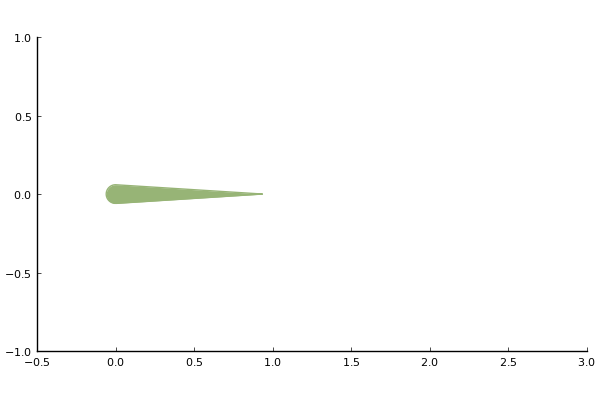

In [8]:
plot(body,xlim=xlim,ylim=ylim)

### The joint placement
We must specify the joint, attaching body 1 (the child) to the inertial system (body 0, the parent). We need
a more detailed form of the `Joint` function now. In this form, we need
to specify how the joint is attached to each body, and how each of its
degrees of freedom move. We will do this piece by piece to explain it.
More details can be found in the documentation for [RigidBodyTools.jl](https://github.com/JuliaIBPM/RigidBodyTools.jl).

To place the joint, we need to specify its position in both the parent's
and the child's coordinate systems. In the parent's system, we can just
place it at the origin, with no rotation. For the child, we place
the joint where we want it on the body (in its own system). $(0,0)$ is the center of the body.

In [9]:
parent_body, child_body = 0, 1
Xp = MotionTransform([0,0],0) # transform from inertial system to joint
xpiv = [0.0,0.0] 
Xc = MotionTransform(xpiv,0.0)

2d motion transform, x = [0.0, 0.0], R = [1.0 0.0; -0.0 1.0]

### The kinematics
We are creating a joint that has three potential degrees of freedom (angle, x, y),
called a `FreeJoint2d`. However, only the angle and x coordinates of the
joint will be allowed to move. Both of these are assigned oscillatory kinematics.

In [10]:
f_Hz = 2.4 # frequency in Hz
U_ms = 0.125 # free stream in m/s
c_m = 0.08 # chord length in m
f_red = f_Hz*c_m/U_ms

f = 1/4
Ω = 2π*f # Flapping angular frequency

Tp = 2π/Ω # Period of flapping
Δα = 5π/180 # Amplitude of pitching
ϕα = π/2 # Pitching phase
adof = OscillatoryDOF(Δα,Ω,ϕα,0.0)

Oscillatory kinematics (amplitude = 0.08726646259971647, ang freq = 1.5707963267948966, phase = 1.5707963267948966, mean velocity = 0.0)

Set the freestream speed to match the reduced frequency

In [11]:
my_params["freestream speed"] = f*len/f_red

0.16276041666666666

In [12]:
# so the Re = Ωc^2/ν is
Re_Ω = my_params["Re"]*len^2*Ω

# and Re = Uc/ν is
Re_U = my_params["Re"]*len*my_params["freestream speed"]

println("Reynolds number based on freestream speed is ",Re_U)

Reynolds number based on freestream speed is 244.140625


Keep the x and y coordinates fixed

In [13]:
xdof = ConstantVelocityDOF(0)
ydof = ConstantVelocityDOF(0)

Constant velocity kinematics (velocity = 0.0)

We put the kinematics into a vector. The degrees of freedom are always ordered `[rotation, x, y]`.

In [14]:
dofs = [adof,xdof,ydof]

3-element Vector{AbstractPrescribedDOFKinematics}:
 Oscillatory kinematics (amplitude = 0.08726646259971647, ang freq = 1.5707963267948966, phase = 1.5707963267948966, mean velocity = 0.0)
 Constant velocity kinematics (velocity = 0.0)
 Constant velocity kinematics (velocity = 0.0)

Finally, create the joint and the motion structure.

In [15]:
joint = Joint(FreeJoint2d,parent_body,Xp,child_body,Xc,dofs)
m = RigidBodyMotion(joint,body)

1 linked system(s) of bodies
   1 bodies
   1 joints


Now animate the motion for a complete cycle (4 time units)

[ Info: Saved animation to /Users/jeff/JuliaProjects/MassivelySeparatedFlows/notebooks/tmp.gif


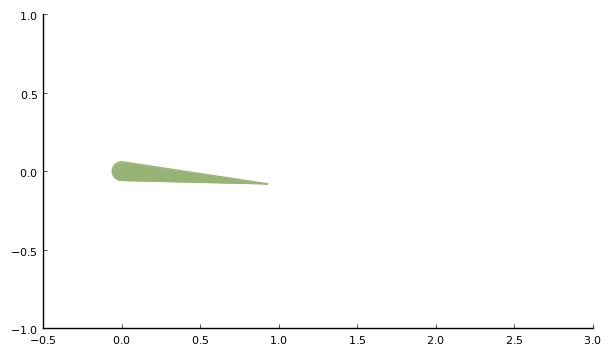

Plots.AnimatedGif("/Users/jeff/JuliaProjects/MassivelySeparatedFlows/notebooks/tmp.gif")
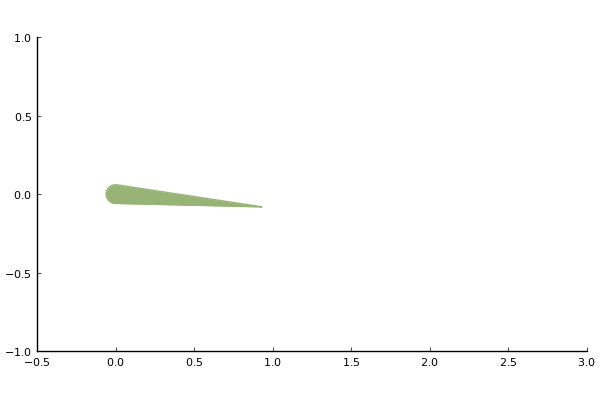

In [16]:
@animate_motion body m Tp/200 Tp xlim ylim

### Boundary condition functions

In [17]:
function my_vsplus(t,x,base_cache,phys_params,motions)
  vsplus = zeros_surface(base_cache)
  surface_velocity_in_translating_frame!(vsplus,x,base_cache,motions,t)
  return vsplus
end

# This is for specifying zero velocity inside the body
function my_vsminus(t,x,base_cache,phys_params,motions)
  vsminus = zeros_surface(base_cache)
  return vsminus
end

bcdict = Dict("exterior" => my_vsplus, "interior" => my_vsminus)

Dict{String, Function} with 2 entries:
  "interior" => my_vsminus
  "exterior" => my_vsplus

### Construct the system structure
Here, we supply both the motion, the boundary condition functions, and the reference body as additional arguments.

In [18]:
sys = viscousflow_system(g,body,phys_params=my_params,bc=bcdict,motions=m,reference_body=1);

### Set up the initial conditions
This is done the usual way

In [19]:
u0 = init_sol(sys)
tspan = (0.0,40.0)
integrator = init(u0,tspan,sys)

t: 0.0
u: (Dual nodes in a (nx = 663, ny = 384) cell grid of type Float64 data
  Number of Dual nodes: (nx = 663, ny = 384), [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [-0.08726646259971647, 0.0, 0.0])

In [20]:
Δt = timestep(u0,sys)

0.0114688

### Solve the problem
Here, we will advance it for one flapping period

In [21]:
@time step!(integrator,10Δt)

  3.914987 seconds (7.36 M allocations: 1.641 GiB, 3.11% gc time)


In [22]:
step!(integrator,6Tp)

### Plot it
Plot the vorticity field in the coordinate system of the body

#### To rotate the plot to its inertial coordinate system

In [23]:
function get_trans_data(sol::ODESolution,sys::ILMSystem,t::Real)
    α = aux_state(sol(t))[1]*180/pi
    trans_data = mpl.transforms.Affine2D().rotate_deg(α)
end

get_trans_data (generic function with 1 method)

In [24]:
function pyplot_field!(ax::Py,field::Function,sol::ODESolution,sys::ILMSystem,t::Real;cmap=mpl.colormaps["RdBu"].reversed(),levels=range(-2.5,2.5,length=30))
    
    f = field(sol,sys,t)
    
    g = sys.base_cache.g
    α = aux_state(sol(t))[1]*180/pi
    x, y = coordinates(f,g)
    
    pts = points(sys)
    xb = [pts.u;]
    yb = [pts.v;]
    

    ax.set_aspect("equal")
    
    trans_data = get_trans_data(sol,sys,t) + ax.transData
    co = ax.contour(x,y,f',levels=levels,transform=trans_data,zorder=1,cmap=cmap)
    bo = ax.fill(xb,yb,color="black",transform=trans_data,zorder=2)
    
    co, bo
end

pyplot_field! (generic function with 1 method)

In [25]:
function animate_vort(i)
    for tp in p1[1].collections
        tp.remove()
    end
    
    for tp in ax.patches
        tp.remove()
    end
    
    iskip = 7 # plot every iskip time step
    t = sol.t[iskip*i+1]
    
    co, bo = pyplot_field!(ax,vorticity,sol,sys,t;cmap=mpl.colormaps["RdBu"].reversed())
    p1[1] = co
    p2[1] = bo
    
    return p1[1].collections + p2[1]
end

animate_vort (generic function with 1 method)

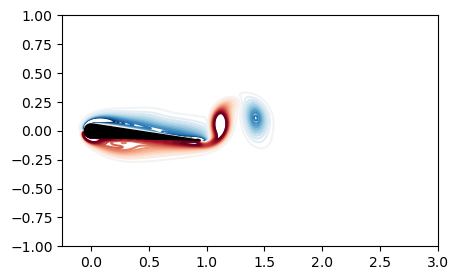

In [26]:
sol = integrator.sol

fig, ax = PythonPlot.subplots(figsize=(5,3))

t = Tp
co, bo = pyplot_field!(ax,vorticity,sol,sys,t)
ax.set_xlim(-0.25,3.0)
ax.set_ylim(-1.0,1.0)
p1 = [co]
p2 = [bo]
display(fig)

In [27]:
ani = anim.FuncAnimation(fig,animate_vort,frames=floor(Int,length(sol.t)/7),interval=40)

Python: <matplotlib.animation.FuncAnimation object at 0x2ce0eced0>

In [28]:
ani.save("yuanhang-newcase-2.gif", bitrate=-1)

Python: None

### Plot the forces and moments
The solution is expressed in co-rotating coordinates. To get the force and
moment in inertial coordinates, we
make use of the `axes` keyword, setting it to 0. The moment is computed
about the center of the body's coordinate system, but we can change that behavior
by using the `force_reference` keyword, setting it to 0, for example,
to compute the moment about the origin of the inertial system.

In [33]:
mom, fx, fy = force(sol,sys,1,axes=0);

Plot these

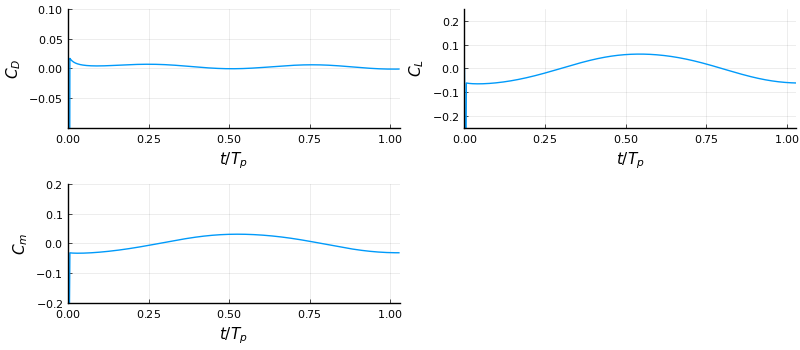

In [34]:
plot(
plot(sol.t/Tp,2*fx/Ω^2,xlim=(0,Inf),ylim=(-0.1,0.1),xlabel="\$t/T_p\$",ylabel="\$C_D\$",legend=:false),
plot(sol.t/Tp,2*fy/Ω^2,xlim=(0,Inf),ylim=(-0.25,0.25),xlabel="\$t/T_p\$",ylabel="\$C_L\$",legend=:false),
plot(sol.t/Tp,2*mom/Ω^2,xlim=(0,Inf),ylim=(-0.2,0.2),xlabel="\$t/T_p\$",ylabel="\$C_m\$",legend=:false),
    size=(800,350)
)